In [150]:
import idx2numpy
import numpy as np

""" LOADING DATASET """
train_images_file = 'assets/MNIST/train-images.idx3-ubyte'
train_images_array = idx2numpy.convert_from_file(train_images_file).T

train_labels_file = 'assets/MNIST/train-labels.idx1-ubyte'
train_labels_array = idx2numpy.convert_from_file(train_labels_file).T

test_images_file = 'assets/MNIST/test-images.idx3-ubyte'
test_images_array = idx2numpy.convert_from_file(test_images_file).T

test_labels_file = 'assets/MNIST/test-labels.idx1-ubyte'
test_labels_array = idx2numpy.convert_from_file(test_labels_file).T

""" NORMALISATION """
def map_values(x):
    return (x / 127.5) - 1

train_images_array = map_values(train_images_array)

test_images_array = map_values(test_images_array)

print(f"Size of an image in each row: {train_images_array.shape[:2]}")
print(f"Number of training examples: {train_images_array.shape[-1]}")

Size of an image in each row: (28, 28)
Number of training examples: 60000


In [151]:
X = train_images_array.reshape(
    (-1, train_images_array.shape[-1])
)

X_test = test_images_array.reshape(
    (-1, test_images_array.shape[-1])
)

# one hot encoding
Y = np.zeros((10, train_labels_array.shape[-1]))
for i in range(len(train_labels_array)):
    Y[train_labels_array[i], i] = 1 

Y_test = np.zeros((10, test_labels_array.shape[-1]))
for i in range(len(test_labels_array)):
    Y_test[test_labels_array[i], i] = 1 

print(f"Training array: {X.shape} \nTraining labels: {Y.shape}")

Training array: (784, 60000) 
Training labels: (10, 60000)


In [152]:
""" UTILS """
def g_h(z):  # for hidden layers
    """
    Try:
    1. sigmoid
    2. tanh
    3. ReLU (using now)
    4. Leaky ReLU
    """
    return np.maximum(0, z)

from scipy.special import expit  # coz my sigmoid implementation fucks up when z is large af

def g_y(z):
    # return 1 / (1 + np.exp(-z))
    return expit(z)

In [153]:
def initialise_parameters(n_x, n_h1, n_h2, n_y):
    # np.random.seed(69)

    W1 = np.random.uniform(-0.1, 0.1, (n_h1, n_x))
    b1 = np.zeros((n_h1, 1))

    W2 = np.random.uniform(-0.1, 0.1, (n_h2, n_h1))
    b2 = np.zeros((n_h2, 1))

    W3 = np.random.uniform(-0.1, 0.1, (n_y, n_h2))
    b3 = np.zeros((n_y, 1))

    parameters = {
        "W1": W1,
        "b1": b1,

        "W2": W2,
        "b2": b2,

        "W3": W3,
        "b3": b3
    }

    return parameters

In [154]:
def layer_sizes(X, Y):
    n_x = X.shape[0]
    n_h1 = 16
    n_h2 = 16
    n_y  = 10
    
    return (n_x, n_h1, n_h2, n_y)

In [155]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']

    W2 = parameters['W2']
    b2 = parameters['b2']
    
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = np.dot(W1, X) + b1
    A1 = g_h(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = g_h(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = g_y(Z3)

    # Caching for backpragation
    cache = {
        "Z1": Z1,
        "A1": A1,
        
        "Z2": Z2,
        "A2": A2,
        
        "Z3": Z3,
        "A3": A3
    }

    return A3, cache

In [156]:
def compute_cost(A3, Y, parameters):
    m = Y.shape[1]
    epsilon = 10**(-8)  # Small constant to avoid division by zero
    L = Y * np.log(A3 + epsilon) + (1 - Y) * np.log(1 - A3 + epsilon)
    cost = (-1/m) * np.sum(L)

    return cost


In [157]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]

    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    W3 = parameters["W3"]
    b3 = parameters["b3"]


    Z1 = cache["Z1"]
    A1 = cache["A1"]

    Z2 = cache["Z2"]
    A2 = cache["A2"]
    
    Z3 = cache["Z3"]
    A3 = cache["A3"]
    

    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    dZ2 = np.dot(W3.T, dZ3) * (A2 > 0)
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * (A1 > 0)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {
        "dW1": dW1,
        "db1": db1,

        "dW2": dW2,
        "db2": db2,
        
        "dW3": dW3,
        "db3": db3
    }
    
    return grads

In [158]:
def update_parameters(parameters, grads, lr):
    W1 = parameters["W1"]
    b1 = parameters["b1"]

    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    

    dW1 = grads["dW1"]
    db1 = grads["db1"]

    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    dW3 = grads["dW3"]
    db3 = grads["db3"]
    
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1

    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    
    W3 = W3 - lr * dW3
    b3 = b3 - lr * db3

    parameters = {
        "W1": W1,
        "b1": b1,

        "W2": W2,
        "b2": b2,

        "W3": W3,
        "b3": b3
    }
    
    return parameters

## Integrating into a `nn_model`

In [167]:
def nn_model(
    X, Y, n_h1, n_h2, 
    lr, decay_steps=10000, decay_rate=0.95,
    max_iterations=10000, print_cost=False
):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[-1]

    # lr decay
    lr = lr
    decay_rate = 0.95
    decay_steps = 10000
    
    parameters = initialise_parameters(n_x, n_h1, n_h2, n_y)
    
    W1 = parameters['W1']
    b1 = parameters['b1']

    W2 = parameters['W2']
    b2 = parameters['b2']
    
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    costs = []

    # Gradient descent
    for i in range(max_iterations):
        # Forward propagation
        A3, cache = forward_propagation(X, parameters)  # cache === {Z1, A1, ...}

        # Cost function
        cost = compute_cost(A3, Y, parameters)
        costs.append(cost)

        # Backpropagation
        grads = backward_propagation(parameters, cache, X, Y)

        # Update rule for each parameter
        parameters = update_parameters(parameters, grads, lr)

        if lr > 10**(-4) and i % decay_steps == 0:
            lr *= decay_rate

        if print_cost==True and i % 100 == 0:
            print (f"Cost after iteration {i}: {cost}")
            
    return parameters, costs

In [160]:
def predict(parameters, X):
    A3, cache = forward_propagation(X, parameters)
    predictions = A3.copy() # np.where(A3 > 0.5, 1, 0)
    
    return predictions

In [161]:
def test_accuracy(parameters, X_test, Y_test):
    predictions = predict(parameters, X_test)
    binary_predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
    correct_predictions = (binary_predictions == Y_test).sum()  # Count the number of correct predictions
    accuracy = (correct_predictions / Y_test.size) * 100  # Calculate accuracy percentage

    print(f"Accuracy = {accuracy}%")

Cost after iteration 0: 6.906432804077718
Cost after iteration 100: 3.2491740811843934
Cost after iteration 200: 2.8580118159670636
Cost after iteration 300: 2.7741440754724436
Cost after iteration 0: 6.906432804077718
Cost after iteration 100: 3.0355405451567563
Cost after iteration 200: 2.156617852408686
Cost after iteration 300: 1.7129159634193183
Cost after iteration 0: 6.906432804077718
Cost after iteration 100: 2.438723380239506
Cost after iteration 200: 1.4047544852838687
Cost after iteration 300: 1.1519885157283505
Cost after iteration 0: 6.906432804077718
Cost after iteration 100: 2.917809421787143
Cost after iteration 200: 2.1767203349216615
Cost after iteration 300: 1.535663985060944
Cost after iteration 0: 6.906432804077718
Cost after iteration 100: 3.2481765200381596
Cost after iteration 200: 3.2296227731643206
Cost after iteration 300: 3.19422296150818


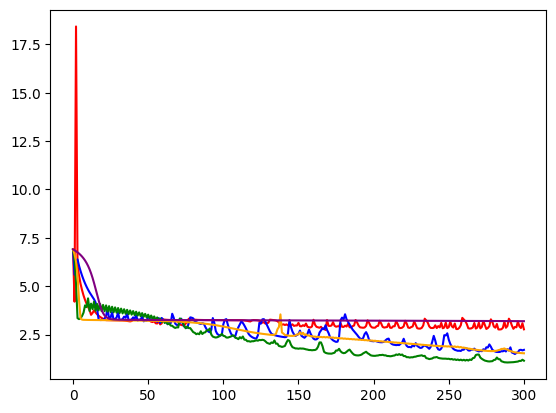

Accuracy = 92.49000000000001%


In [162]:
import matplotlib.pyplot as plt
import pickle

# Define the colors for each plot
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, lr in enumerate([0.5, 0.25, 0.1, 0.05, 0.01]):
    parameters, costs = nn_model(X, Y, n_h1=16, n_h2=16, lr=lr, max_iterations=301, print_cost=True)
    x = np.arange(len(costs))
    plt.plot(x, costs, color=colors[i])

plt.show()

=> 0.1 is the best learning rate! </br>
now lets test how decay might help

Cost after iteration 0: 6.906432804077718
Cost after iteration 100: 2.438723380239506
Cost after iteration 200: 1.4047544852838687
Cost after iteration 300: 1.1519885157283505
Cost after iteration 400: 0.8731858565832723
Cost after iteration 500: 0.7319864848455381


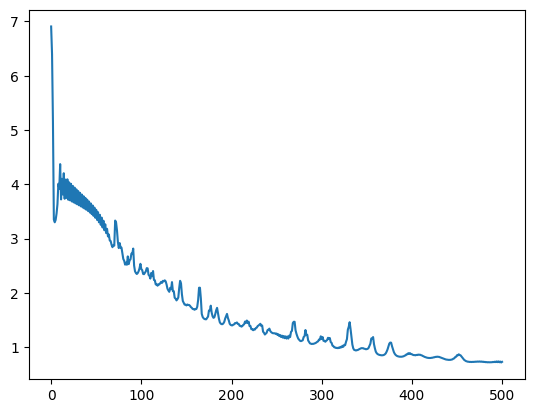

Accuracy = 97.729%


In [170]:
import matplotlib.pyplot as plt
import pickle

parameters, costs = nn_model(
    X, Y, n_h1=16, n_h2=16, 
    lr=0.1, decay_steps=100, decay_rate=0.5,
    max_iterations=501, print_cost=True)
x = np.arange(len(costs))
plt.plot(x, costs)
plt.show()

# Save data for future use
with open("params.pickle", "wb") as file:
    pickle.dump(parameters, file)

# Testing
with open("params.pickle", "rb") as file:
    saved_parameters = pickle.load(file)

test_accuracy(saved_parameters, X_test, Y_test)

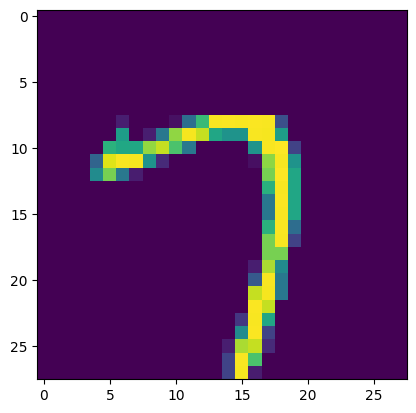

[0.0, 0.0, 0.0, 0.02, 0.0, 0.01, 0.0, 0.93, 0.0, 0.13]
7


In [244]:
import matplotlib.pyplot as plt
import random

i = random.randint(0, test_images_array.shape[1])

x = test_images_array[:, :, i]
y = test_labels_array[i]
plt.imshow(x.T)
plt.show()

x = x.reshape(-1, 1)

with open("params.pickle", "rb") as file:
    saved_parameters = pickle.load(file)

predictions = predict(saved_parameters, x).tolist()
rounded_predictions = [round(pred[0], 2) for pred in predictions]
print(rounded_predictions)
print(rounded_predictions.index(max(rounded_predictions)))
